In [1]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import seaborn

#### Ładujemy dane

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
data = mnist.data
target = mnist.target.astype(np.int32)

# zmieniamy target na kodowanie one_hot
target = np.eye(10)[target]

# tasujemy dane (ustawiamy seed na konkretna wartosc,
#                zeby pozniej porownac rezultaty)
np.random.seed(1337)
shuffle = np.random.permutation(len(data))
data = data[shuffle]
target = target[shuffle]

# ostatnie 10k przykladow traktujemy jako zbior
# do walidacji wynikow
valid_data = data[-10000:]
valid_target = target[-10000:]

data = data[:-10000]
target = target[:-10000]

#### Tworzymy graf obliczeniowy

In [3]:
graph = tf.Graph()
with graph.as_default():
    x = tf.placeholder(tf.float32, shape=[None, 28 * 28])
    y = tf.placeholder(tf.float32, shape=[None, 10])

    # wagi pierwszej warstwy
    w1 = tf.Variable(tf.truncated_normal(shape=[28 * 28, 128], stddev=0.01))
    b1 = tf.Variable(tf.zeros(shape=[128]))
    
    # wagi drugiej warstwy
    w2 = tf.Variable(tf.truncated_normal(shape=[128, 10], stddev=0.01))
    b2 = tf.Variable(tf.zeros(shape=[10]))
    
    # pierwsza warstwa (zamieniamy funkcje aktywacji z sigmoid na relu)
    h = tf.matmul(x, w1) + b1
    h = tf.nn.relu(h)
    
    # druga warstwa (zmieniamy funkcje aktywacji z sigmoid na softmax)
    h = tf.matmul(h, w2) + b2
    y_ = tf.nn.softmax(h)
    
    # funkcja straty (zmieniamy z MSE na CrossEntropy)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=h, labels=y))
    
    # tworzymy optimalizator i ustawiamy learning rate
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    
    # tworzymy operacje trenowania (minimalizowanie straty)
    train_step = optimizer.minimize(loss)
    
    # dodatkowo liczenie dokladnosci
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_, axis=1),
                                               tf.argmax(y, axis=1)),
                                      tf.float32))

#### Tworzymy sesję i trenujemy sieć


Epoch 0
[60000/60000] loss = 0.128788590431213383
Epoch 1
[60000/60000] loss = 0.0353603325784206445
Epoch 2
[60000/60000] loss = 0.0153165375813841826
Epoch 3
[60000/60000] loss = 0.0105259744450449945
Epoch 4
[60000/60000] loss = 0.01597666740417480547

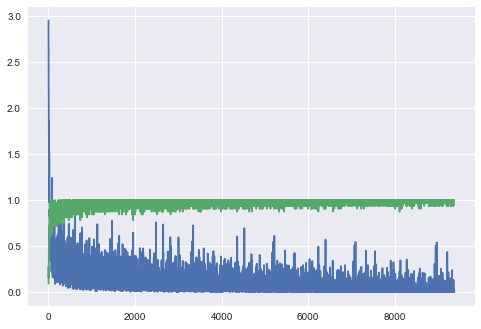

Validation accuracy: 0.9728


In [4]:
epochs = 5
batch_size = 32

# tworzymy sesje dla utworzonego wczesniej grafu
with tf.Session(graph=graph) as sess:
    # inicjalizujemy zmienne
    sess.run(tf.global_variables_initializer())
    
    losses = []
    acc = []
    
    for e in range(epochs):
        print('\nEpoch {}'.format(e))
        for b in range(0, len(data), batch_size):
            # pobieramy kolejna partie danych treningowych
            be = min(len(data), b + batch_size)
            x_batch = data[b: be]
            y_batch = target[b: be]

            # uruchamiamy obliczenia dla [loss, accuracy, train_step]
            l, a, _ = sess.run([loss, accuracy, train_step],
                               feed_dict={x: x_batch, y: y_batch})
            losses += [l]
            acc += [a]
            
            print('\r[{:5d}/{:5d}] loss = {}'.format(be, len(data), l), end='')
        
    # policzymy teraz dokladnosc dla validation set
    validation_accuracy = 0
    for b in range(0, len(valid_data), batch_size):
        be = min(len(valid_data), b + batch_size)
        a = sess.run(accuracy, feed_dict={x: valid_data[b: be], y: valid_target[b: be]})
        validation_accuracy += a * (be - b)
    validation_accuracy /= len(valid_data)
    
plt.plot(losses)
plt.plot(acc)
plt.show()

print('Validation accuracy: {}'.format(validation_accuracy))